In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import seaborn as sns
import os as os
import sys as sys
sys.path.append('/home/qiuaodon/Desktop/PanCancer_scRNA_analysis/utils/')
from scRNA_utils import *
import operator as op
import matplotlib.colors as mcolors

# load in sc data

In [2]:
data_dir_NHDP = "/home/qiuaodon/Desktop/project_data_new/"
adata_T = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_T_cells.h5ad')
adata_1 = adata_T[adata_T.obs['leiden'] == '4', :]
adata_M = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_M_cells.h5ad')
adata_2 = adata_M[adata_M.obs['cell_type'] == 'Dendritic', :]

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


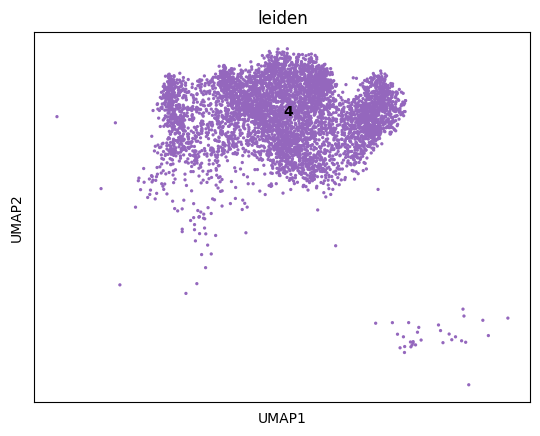

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


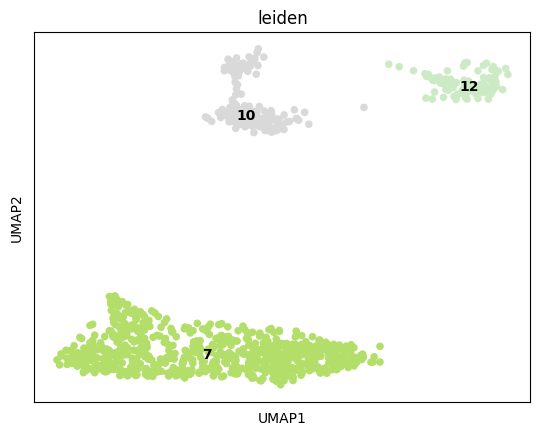

In [3]:
sc.pl.umap(adata_1, color='leiden', legend_loc='on data')
sc.pl.umap(adata_2, color='leiden', legend_loc='on data')

In [4]:
adata_1_pseudo = scRNA2PseudoBulkAnnData(adata_1, sample_id_col='sample_id')
adata_2_pseudo = scRNA2PseudoBulkAnnData(adata_2, sample_id_col='sample_id')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# because some samples are missing, we need to add them to the dataset
# to make sure nosamplefiltered
from scRNA_utils import add_missing_samples
import anndata
# Extract sample_ids
sample_ids_1 = set(adata_1_pseudo.obs['sample_id'])
sample_ids_2 = set(adata_2_pseudo.obs['sample_id'])

# Identify missing sample_ids
missing_sample_ids_1 = sample_ids_2 - sample_ids_1
missing_sample_ids_2 = sample_ids_1 - sample_ids_2

# Add missing sample_ids to each dataset
adata_1_pseudo = add_missing_samples(adata_1_pseudo, missing_sample_ids_1)
adata_2_pseudo = add_missing_samples(adata_2_pseudo, missing_sample_ids_2)
# Sort the obs DataFrame by sample_id in both AnnData objects
adata_1_pseudo = adata_1_pseudo[adata_1_pseudo.obs.sort_values('sample_id').index]
adata_2_pseudo = adata_2_pseudo[adata_2_pseudo.obs.sort_values('sample_id').index]

# Verify that both datasets have the same sample_ids and in the same order
assert (adata_1_pseudo.obs['sample_id'].values == adata_2_pseudo.obs['sample_id'].values).all()

# Now adata_T_pseudo and adata_Endo_pseudo have the same sample_ids in the same order

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, n

# prepare data matrix for IVtest

In [6]:
adata_1_pseudo.raw = adata_1_pseudo
adata_2_pseudo.raw = adata_2_pseudo

In [7]:
DEG_1 = paird_ttest(adata_1, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')
DEG_2 = paird_ttest(adata_2, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')

Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
DEG_1 = DEG_1[DEG_1['pval'] < 0.05]
DEG_2 = DEG_2[DEG_2['pval'] < 0.05]
gene_1 = DEG_1.index.tolist()
gene_2 = DEG_2.index.tolist()

# Filter out invalid gene names
gene_1 = [gene for gene in gene_1 if gene in adata_1_pseudo.var_names]
gene_2 = [gene for gene in gene_2 if gene in adata_2_pseudo.var_names]

gene_1_matrix = adata_1_pseudo[:, gene_1].X
gene_2_matrix = adata_2_pseudo[:, gene_2].X
gene_1_df = pd.DataFrame(gene_1_matrix, columns=gene_1, index=adata_1_pseudo.obs['sample_id'])
gene_2_df = pd.DataFrame(gene_2_matrix, columns=gene_2, index=adata_2_pseudo.obs['sample_id'])
gene_1_df.columns = [i + '_T' for i in gene_1_df.columns]
gene_2_df.columns = [i + '_M' for i in gene_2_df.columns]
gene_df = gene_1_df
gene_df = pd.merge(gene_df, gene_2_df, on='sample_id')

In [9]:
gene_df['treatment'] = gene_df.index.str.contains('On').astype(int)
# get patient id from sample id remove the _On or _Pre
gene_df['patient_id'] = gene_df.index.str.replace('_On', '').str.replace('_Pre', '')
gene_df['treatment'].value_counts()

1    30
0    29
Name: treatment, dtype: int64

In [10]:
# export the gene_df to csv
gene_df.to_csv(data_dir_NHDP + 'gene_df_CD8EX_DC.csv')
# gene_df.to_csv(data_dir_NHDP + 'gene_df_CD4EX_Endo_filtered.csv')

# load in IV result and perform CIT

In [11]:
DEG_pairs = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/IV_regression_results_CD8EXvsDC.xlsx')
# DEG_pairs = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/IV_regression_results_CD4EXvsEndo_filtered.xlsx')
# drop the p_value column and r_squared column
DEG_pairs = DEG_pairs.drop(columns=['p_value', 'r_squared'])
# set the first two columns as g1 and g2 in DEG_pairs
DEG_pairs = DEG_pairs.rename(columns = {'gene_T':'g1', 'gene_cell':'g2'})

In [12]:
DEG_pairs

,g1,g2
0,ANKRD28_T,AREG_M
1,ANKRD28_T,GRASP_M
2,ANKRD28_T,PFKFB3_M
3,ANKRD28_T,SESN1_M
4,ATF3_T,C1QB_M
...,...,...
223,ZFP36L1_T,PFKFB3_M
224,ZFP36L1_T,PMAIP1_M
225,ZFP36L1_T,SMIM3_M
226,ZFP36L1_T,SOCS1_M


In [13]:

from scRNA_utils import calculate_gene_correlation, calculate_geneLR_correlation, calculate_residuals_correlation

calculate_gene_correlation(DEG_pairs, adata_1_pseudo, adata_2_pseudo)

,g1,g2,g1vsg2_correlation
0,ANKRD28_T,AREG_M,0.164245
1,ANKRD28_T,GRASP_M,0.260376
2,ANKRD28_T,PFKFB3_M,0.266516
3,ANKRD28_T,SESN1_M,0.128277
4,ATF3_T,C1QB_M,0.474174
...,...,...,...
223,ZFP36L1_T,PFKFB3_M,-0.102665
224,ZFP36L1_T,PMAIP1_M,-0.131955
225,ZFP36L1_T,SMIM3_M,-0.360415
226,ZFP36L1_T,SOCS1_M,-0.158138


In [14]:
# Combine the two conditions using the logical OR operator
DEG_pairs = DEG_pairs[(DEG_pairs['g1vsg2_correlation'] > 0.3) | (DEG_pairs['g1vsg2_correlation'] < -0.3)]

# sort the DEG_pairs by g1vsg2_correlation
DEG_pairs = DEG_pairs.sort_values(by='g1vsg2_correlation', ascending=False)
DEG_pairs

,g1,g2,g1vsg2_correlation
47,ERN1_T,ACSL1_M,0.706524
107,MARCH9_T,LOH12CR2_M,0.668025
42,DTHD1_T,HIST1H1B_M,0.651851
14,C1QB_T,CEBPD_M,0.651526
25,CRYBG1_T,HIST1H1B_M,0.608081
...,...,...,...
50,FASLG_T,AL135925.1_M,-0.375707
104,KLF10_T,ERN1_M,-0.375729
217,ZFP36L1_T,AL135925.1_M,-0.378421
87,HNRNPLL_T,IDH1_M,-0.395806


In [15]:
# check if the g1 and g2 in adata_CD4EX and adata_Mono separately and expression not all zero
g1 = list(DEG_pairs['g1'])
g2 = list(DEG_pairs['g2'])
g1_in_CD4EX = [i for i in gene_df.columns if np.sum(gene_df.loc[:, i] == 0) < 20]
g2_in_Endo = [i for i in gene_df.columns if np.sum(gene_df.loc[:, i] == 0) < 20]
DEG_pairs = DEG_pairs[DEG_pairs['g1'].isin(g1_in_CD4EX) & DEG_pairs['g2'].isin(g2_in_Endo)]
DEG_pairs

,g1,g2,g1vsg2_correlation
155,PRDM1_T,TSC22D3_M,0.595791
210,TSC22D3_T,TSC22D3_M,0.550780
203,TSC22D3_T,PMAIP1_M,0.512741
191,TSC22D3_T,FKBP5_M,0.498488
148,PRDM1_T,PFKFB3_M,0.476828
145,PRDM1_T,GRASP_M,0.466073
142,PRDM1_T,FKBP5_M,0.457300
147,PRDM1_T,NEAT1_M,0.435692
202,TSC22D3_T,PFKFB3_M,0.421496
199,TSC22D3_T,IRF4_M,0.405031


In [16]:
lrpair = pd.read_csv('/home/qiuaodon/Desktop/project_data_new/lr_network_unique.tsv', sep='\t')
# get the lr pairs including ligand(from) and receptor(to) from the lrpair file with database as 'kegg'
lrpair = lrpair[['from', 'to']]
# change from as L and to as R
lrpair.columns = ['L', 'R']
lrpair

,L,R
0,CXCL1,CXCR2
1,CXCL2,CXCR2
2,CXCL3,CXCR2
3,CXCL5,CXCR2
4,PPBP,CXCR2
...,...,...
12016,CXCL6,PIGR
12017,RLN1,GPR25
12018,RLN1,RAMP3
12019,PIK3CB,TNFRSF10A


In [17]:
# check if the L and R in adata_CD4EX and adata_Mono separately and expression not all zero
L = list(lrpair['L'])
R = list(lrpair['R'])
L_in_1 = list(set(L).intersection(adata_1.var_names))
R_in_2 = list(set(R).intersection(adata_2.var_names))
L_in_1 = [x for x in L_in_1 if np.sum(adata_1_pseudo[:, x].X == 0) < 0.75 * adata_1_pseudo.shape[0]]
R_in_2 = [x for x in R_in_2 if np.sum(adata_2_pseudo[:, x].X == 0) < 0.75 * adata_2_pseudo.shape[0]]
print('L_in_CD4EX:', len(L_in_1))
print('R_in_2:', len(R_in_2))

L_in_CD4EX: 81
R_in_2: 71


In [18]:
# remove the LR pairs not in L_in_CD4EX and R_in_DC
lrpair = lrpair[lrpair['L'].isin(L_in_1)]
lrpair = lrpair[lrpair['R'].isin(R_in_2)]
print('lrpair_kegg:', lrpair.shape)

lrpair_kegg: (126, 2)


In [18]:
# check if CXCL13-ACKR1 in the LR_pairs
lrpair[(lrpair['L'] == 'CXCL13') & (lrpair['R'] == 'ACKR1')]
new_pair = pd.DataFrame({'L': ['CXCL13'], 'R': ['ACKR1']})
lrpair = pd.concat([lrpair, new_pair], ignore_index=True)


## CIT using fisher-z

In [19]:
lrpair

,L,R
10,CXCL10,CXCR3
15,XCL1,XCR1
16,XCL2,XCR1
51,OSM,IL6ST
147,TNFSF10,TNFRSF11B
...,...,...
11599,PTPRF,MCC
11654,PTPRM,PTPRK
11665,PLXNB2,PTPRK
11677,ITGB1,DAB2


In [20]:
DEG_pairs

,g1,g2,g1vsg2_correlation
155,PRDM1_T,TSC22D3_M,0.595791
210,TSC22D3_T,TSC22D3_M,0.550780
203,TSC22D3_T,PMAIP1_M,0.512741
191,TSC22D3_T,FKBP5_M,0.498488
148,PRDM1_T,PFKFB3_M,0.476828
145,PRDM1_T,GRASP_M,0.466073
142,PRDM1_T,FKBP5_M,0.457300
147,PRDM1_T,NEAT1_M,0.435692
202,TSC22D3_T,PFKFB3_M,0.421496
199,TSC22D3_T,IRF4_M,0.405031


In [21]:
results = CIT_test(DEG_pairs, lrpair, adata_1_pseudo, adata_2_pseudo, gene_df, method = 'fisherz', p_value_threshold=0.05)

In [22]:
#calculate the correlation between g1 and g2
calculate_gene_correlation(results, adata_1_pseudo, adata_2_pseudo)
#calculate the residuals correlation between g1, g2 and LR
calculate_residuals_correlation(results, adata_1_pseudo, adata_2_pseudo)

,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,TSC22D3_T,IRF4_M,ANXA1,CXCR4,0.066057,0.405031,0.242888
1,PRDM1_T,PMAIP1_M,CALR,IL7R,0.051900,0.403855,0.256281
2,TSC22D3_T,ERN1_M,CCL5,CXCR3,0.186622,0.362923,0.176216
3,TSC22D3_T,ERN1_M,CXCL13,CXCR4,0.052218,0.362923,0.255949
4,TSC22D3_T,ERN1_M,ANXA1,CXCR3,0.135621,0.362923,0.198549
...,...,...,...,...,...,...,...
92,TSC22D3_T,ZFP36L2_M,ITGB1,CD36,0.071374,0.306079,0.238449
93,TSC22D3_T,ZFP36L2_M,ITGAM,PLAUR,0.054431,0.306079,0.253687
94,TSC22D3_T,ZFP36L2_M,ITGA4,CXCR4,0.564233,0.306079,0.077588
95,TSC22D3_T,ZFP36L2_M,PECAM1,CXCR4,0.057104,0.306079,0.251052


In [23]:
# save results to excel
results.to_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_CD8EXvsDC_fisherz_nosamplefiltered.xlsx')

In [10]:
# results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_CD4EXvsEndo_fisherz_nosamplefiltered.xlsx')

## group the DEGpairs together using L and R

In [26]:
#results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_CD4EXvsDC_fisherz_nosamplefiltered.xlsx')
# results = results.drop(columns=['Unnamed: 0'])
# # Remove the suffix '_X' from g1 and g2
results['g1'] = results['g1'].str.replace(r'_\w+', '', regex=True)
results['g2'] = results['g2'].str.replace(r'_\w+', '', regex=True)

In [27]:
results

,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,TSC22D3,IRF4,ANXA1,CXCR4,0.066057,0.405031,0.242888
1,PRDM1,PMAIP1,CALR,IL7R,0.051900,0.403855,0.256281
2,TSC22D3,ERN1,CCL5,CXCR3,0.186622,0.362923,0.176216
3,TSC22D3,ERN1,CXCL13,CXCR4,0.052218,0.362923,0.255949
4,TSC22D3,ERN1,ANXA1,CXCR3,0.135621,0.362923,0.198549
...,...,...,...,...,...,...,...
92,TSC22D3,ZFP36L2,ITGB1,CD36,0.071374,0.306079,0.238449
93,TSC22D3,ZFP36L2,ITGAM,PLAUR,0.054431,0.306079,0.253687
94,TSC22D3,ZFP36L2,ITGA4,CXCR4,0.564233,0.306079,0.077588
95,TSC22D3,ZFP36L2,PECAM1,CXCR4,0.057104,0.306079,0.251052


In [28]:
results['R'].unique()

array(['CXCR4', 'IL7R', 'CXCR3', 'VIPR2', 'ICAM1', 'CD40', 'LRP5',
       'P2RY14', 'PLAUR', 'TFRC', 'DSG2', 'CDH1', 'CCR2', 'CD36'],
      dtype=object)

In [29]:
results['R'].nunique()

14

In [31]:
import pandas as pd
grouped_results = results.groupby(["L", "R"])

# Display grouped data
grouped_dict = { (ligand, receptor): group for (ligand, receptor), group in grouped_results }

# Create a new DataFrame to hold the GEM1 and GEM2 groupings
grouped_data = []
tracked_gem1 = set()
tracked_gem2 = set()

min_gene_num = 2

# Temporary list to hold data before creating DataFrame
temp_data = []

for (ligand, receptor), group in grouped_results:
    gem1 = group["g1"].drop_duplicates().tolist()
    gem2 = group["g2"].drop_duplicates().tolist()
    
    # Check the overlap between current GEM_g1 and previously tracked GEM_g1
    overlap_gem1 = len(set(gem1) & tracked_gem1)
    overlap_gem2 = len(set(gem2) & tracked_gem2)
    
    # Filter to include only those with at least three genes in GEM_g1 and GEM_g2
    # and where the overlap is below the maximum allowable threshold
    if len(gem1) > min_gene_num :
        temp_data.append({
            "Ligand": ligand,
            "Receptor": receptor,
            "GEM_g1": gem1,
            "GEM_g2": gem2,
            "Num_genes_g1": len(gem1),
            "Num_genes_g2": len(gem2)
        })
        # Update the tracked GEM_g1 and GEM_g2 sets
        tracked_gem1.update(gem1)
        tracked_gem2.update(gem2)

# Convert the temporary data to a DataFrame
grouped_df = pd.DataFrame(temp_data)

# Function to find overlapping rows
def find_overlapping_rows(df, column_name):
    overlap_info = []
    for index, row in df.iterrows():
        current_set = set(row[column_name])
        overlapping_rows = []
        for other_index, other_row in df.iterrows():
            if index != other_index:
                other_set = set(other_row[column_name])
                overlap = len(current_set & other_set)
                if overlap > len(current_set) / 3: # Set the threshold for overlap
                    overlapping_rows.append(other_index)
        overlap_info.append(overlapping_rows)
    return overlap_info

# Add columns for overlapping rows in GEM_g1 and GEM_g2
grouped_df["Overlapping_g1"] = find_overlapping_rows(grouped_df, "GEM_g1")
grouped_df["Overlapping_g2"] = find_overlapping_rows(grouped_df, "GEM_g2")

grouped_df


,Ligand,Receptor,GEM_g1,GEM_g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2
0,CCL5,CXCR3,"[TSC22D3, NFKBIA, PRDM1, HNRNPLL]","[ERN1, DDIT4, IRF4, SIDT1, GRASP, TSC22D3, SOC...",4,9,"[1, 2, 3, 4]","[1, 2, 3]"
1,CCL5,CXCR4,"[TSC22D3, PRDM1, HNRNPLL, NFKBIA]","[ERN1, DDIT4, GLUL, SIDT1, GRASP, PFKFB3, TSC2...",4,10,"[0, 2, 3, 4]","[0, 2, 3, 4]"
2,CXCL13,CXCR4,"[TSC22D3, NFKBIA, PRDM1]","[ERN1, GRASP, TSC22D3, SOCS1, RNF144B, ZFP36L2]",3,6,"[0, 1, 3, 4]","[0, 1, 3, 4]"
3,ITGA4,CXCR4,"[TSC22D3, NFKBIA, PRDM1]","[ERN1, DDIT4, TSC22D3, SOCS1, RNF144B, ZFP36L2]",3,6,"[0, 1, 2, 4]","[0, 1, 2]"
4,ITGAM,PLAUR,"[TSC22D3, HNRNPLL, PRDM1]","[GRASP, PFKFB3, SOCS1, ZFP36L2]",3,4,"[0, 1, 2, 3]","[0, 1, 2, 3]"


In [32]:
# export the grouped_df to xlsx
grouped_df.to_excel('/home/qiuaodon/Desktop/project_data_new/grouped_GEM_CD8EXvsDC_fisherz.xlsx')

## draw heatmap

In [ ]:
top_genes_M = [
    'RNF144B',
    'SLC1A3',
    
    'TNFAIP3',
    'CH25H',
    'FKBP5',
    'CLN8',
    'GRASP',
    'SMIM3',
    'DUSP6',
    'HIST1H4H'
]
top_genes_T = [
    'CH25H',
    'TSC22D3',
    'TNFAIP3',
    'BIRC3',
    'SPON2',
    'ZFP36',
    'SLA',
    'ZFP36',
    'TXNIP',
    'IER2',
    'KLF10'
]

In [ ]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr 
# Remove the sample_id that are not in the adata_T_pseudo
adata_M_pseudo = adata_M_pseudo[adata_M_pseudo.obs['sample_id'].isin(adata_T_pseudo.obs['sample_id'])]
adata_T_pseudo = adata_T_pseudo[adata_T_pseudo.obs['sample_id'].isin(adata_M_pseudo.obs['sample_id'])]

# Initialize an empty matrix to store the correlation values
corr_matrix = np.zeros((len(top_genes_T), len(top_genes_M)))
pval_matrix = np.zeros((len(top_genes_T), len(top_genes_M)))

# Calculate the correlation between the top genes of T and M cells
for i, gene_T in enumerate(top_genes_T):
    for j, gene_M in enumerate(top_genes_M):
        # remove the '_T' and '_M' from the gene names
        gene_T = gene_T.replace('_T', '')
        gene_M = gene_M.replace('_M', '')
        # Get the expression data of the two genes and flatten them to 1D arrays
        gene_T_expression = adata_T_pseudo[:, adata_T_pseudo.var_names == gene_T].X.flatten()
        gene_M_expression = adata_M_pseudo[:, adata_M_pseudo.var_names == gene_M].X.flatten()
        
        # Calculate the correlation
        corr, pval = spearmanr(gene_T_expression, gene_M_expression)
        
        # Store the correlation value in the matrix
        corr_matrix[i, j] = corr
        pval_matrix[i, j] = -np.log10(pval)


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=top_genes_M, yticklabels=top_genes_T)
plt.title('Correlation between Highly Correlated Genes of CD4EX and M')
plt.xlabel('M Genes')
plt.ylabel('CD4EX Genes')
plt.show()

In [ ]:

# Plotting the heatmap with correlation values
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1,
                      xticklabels=top_genes_M, yticklabels=top_genes_T,
                      annot=False)  # Turn off default annotation

# Overlaying the correlation values and -log10 of p-values
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{corr_matrix[i, j]:.2f}\n({pval_matrix[i, j]:.2f})',
                 horizontalalignment='center', verticalalignment='center', fontsize=11, color='black' if abs(corr_matrix[i, j]) > 0.5 else 'black')

plt.title('Correlation between Top DEGs of CD4EX and M')
plt.xlabel('M Genes')
plt.ylabel('CD4EX Genes')
plt.show()

In [ ]:
colors = ["grey", "blue"]  # Start with grey and end with blue
cmap = mcolors.LinearSegmentedColormap.from_list("grey_to_blue", colors)


In [ ]:
sc.pl.umap(adata_CD4EX, color = ['SPON2', 'SELL'], color_map = cmap)

In [ ]:
sc.pl.umap(adata_M, color = ['FKBP5', 'MADCAM1'], color_map = cmap)

In [ ]:
sc.pl.umap(adata_CD4EX, color = 'timepoint')
sc.pl.umap(adata_M, color = 'timepoint')

#### plot the scatter plots


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr, pearsonr

def plot_CIT_DEGcorr(g1, g2, L, R, DEG_exp, pseudo_1, pseudo_2):
    # Define a custom palette
    palette = {'pre': "#E69F00", 'on': "#56B4E9"}
    #replace the treatment column 0 pre and 1 on
    gene_df['treatment'] = gene_df['treatment'].replace({0: 'pre', 1: 'on'})
    # Set font sizes
    title_fontsize = 14
    axis_fontsize = 14
    legend_fontsize = 12

    def adjust_plot_limits(ax, x_data, y_data):
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

    # Plot the jointplot between DEG of g1 and g2
    g1_exp = DEG_exp[g1]
    g2_exp = DEG_exp[g2]
    df1 = pd.DataFrame({g1: g1_exp, g2: g2_exp, 'treatment': DEG_exp['treatment']})
    df1 = df1.dropna()
    g = sns.jointplot(x=g1, y=g2, data=df1, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x=g1, y=g2, data=df1, scatter=False, ax=g.ax_joint, color='black')
    adjust_plot_limits(g.ax_joint, df1[g1], df1[g2])
    
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)
    cor = pearsonr(df1[g1], df1[g2])[0]
    plt.suptitle(f'Correlation between {g1} and {g2} is {cor:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.95)
    plt.show()

     # Plot the jointplot between DEG of g1 and g2 residue
    L_values = pseudo_1[:, L].X.toarray().flatten()
    R_values = pseudo_2[:, R].X.toarray().flatten()
    L_R = L_values * R_values
    X = sm.add_constant(L_R)

    # Fit OLS model for g2
    model_g2 = sm.OLS(g2_exp, X).fit()
    residuals_g2 = model_g2.resid

    # Fit OLS model for g1
    model_g1 = sm.OLS(g1_exp, X).fit()
    residuals_g1 = model_g1.resid

    #   Create DataFrame for residuals
    df_res = pd.DataFrame({
        'G_1_residual': residuals_g1,
        'G_2_residual': residuals_g2,
        'treatment': DEG_exp['treatment']
    })

    # Plot the residuals
    g = sns.jointplot(x='G_1_residual', y='G_2_residual', data=df_res, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x='G_1_residual', y='G_2_residual', data=df_res, scatter=False, ax=g.ax_joint, color='black')

    # Adjust plot limits if needed
    adjust_plot_limits(g.ax_joint, df_res['G_1_residual'], df_res['G_2_residual'])

    # Customize plot appearance
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)

    # Calculate and display correlation
    corr_res = spearmanr(df_res['G_1_residual'], df_res['G_2_residual'])[0]
    plt.suptitle(f'Correlation between residuals of G_1 and G_2 is {corr_res:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.95)
    plt.show()




In [ ]:
gene_df['GZMA_Endo']

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

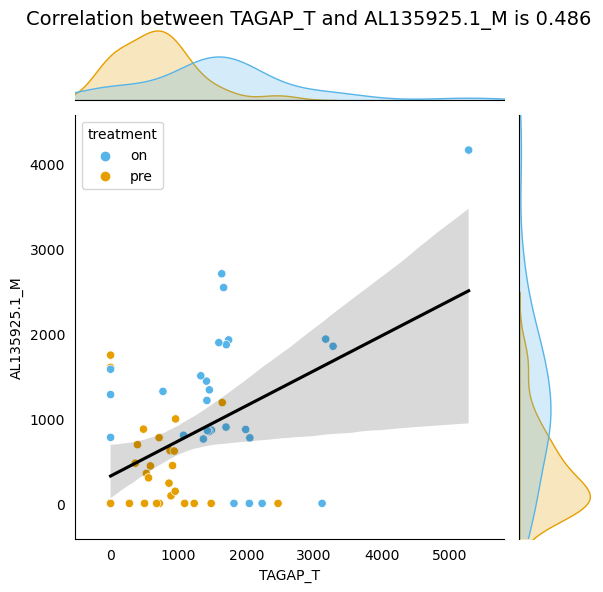

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


KeyError: 'TACR2'

In [27]:
plot_CIT_DEGcorr('TAGAP_T', 'AL135925.1_M', 'XCL2', 'TACR2', gene_df, adata_1_pseudo, adata_2_pseudo)